In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
np.random.seed(0)
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier

#below needed to display decision tree
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
# from sklearn.metrics import mean_squared_error

import json
import requests
from bs4 import BeautifulSoup

#import my function files
import webscrape_wiki_table
import config
import query_helper
import time

#utilities file for timer
from utilities import *

/Users/gabrielseemann/anaconda3/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


### Clean mushroom data

In [2]:
hymeniumType =  ['gills'   
                ,'pores'
                ,'smooth'
                ,'ridges'
                ,'teeth'
                ,'gleba']

In [3]:
capShape =  ['campanulate'
            ,'conical'
            ,'convex'
            ,'depressed'
            ,'flat'
            ,'infundibuliform'
            ,'offset'
            ,'ovate'
            ,'umbilicate'
            ,'umbonate'
            ,'no'
            ,'NA']

In [4]:
whichGills = ['adnate'
            ,'adnexed'
            ,'decurrent'
            ,'emarginate'
            ,'free'
            ,'seceding'
            ,'sinuate'
            ,'subdecurrent'
            ,'no'
            ,'NA']

In [5]:
stipeCharacter = ['bare'
                ,'ring'
                ,'volva'
                ,'ring_and_volva'
                ,'cortina'
                ,'NA']

In [6]:
sporePrintColor = ['black'
                    ,'blackish-brown'
                    ,'brown'
                    ,'buff'
                    ,'cream'
                    ,'green'
                    ,'ochre'
                    ,'olive'
                    ,'olive-brown'
                    ,'pink'
                    ,'pinkish-brown'
                    ,'purple'
                    ,'purple-black'
                    ,'purple-brown'
                    ,'reddish-brown'
                    ,'salmon'
                    ,'tan'
                    ,'white'
                    ,'yellow'
                    ,'yellow-orange'
                    ,'yellow-brown']

In [7]:
ecologicalType =['mycorrhizal'
                ,'parasitic'
                ,'saprotrophic']

In [8]:
howEdible = ['choice'
            ,'edible'
            ,'inedible'
            ,'unpalatable'
            ,'caution'
            ,'psychoactive'
            ,'poisonous'
            ,'allergenic'
            ,'deadly'
            ,'unknown']

In [9]:
mushroom_features = [hymeniumType, capShape, whichGills, stipeCharacter, sporePrintColor, ecologicalType, howEdible]

In [10]:
query ='''SELECT * FROM mushroom.wiki_mush;)'''

In [11]:
df = query_helper.query_to_df(query)
df.head()

,name,hymeniumType,capShape,whichGills,stipeCharacter,sporePrintColor,ecologicalType,howEdible
0,Lysurus mokusin,smooth hymenium,no distinct cap,hymenium attachment is irregular or not applic...,stipe is bare,spore print is olive-brown,ecology is saprotrophic,edibility: unknown
1,Agaricus abruptibulbus,gills on hymenium,cap is convex\n or flat,hymenium is free,stipe has a ring,spore print is brown,ecology is saprotrophic,edibility: edible
2,Agaricus amicosus,gills on hymenium,cap is convex\n or flat,hymenium is free,stipe has a ring,spore print is brown,ecology is saprotrophic,edibility: choice
3,Agaricus arvensis,gills on hymenium,cap is convex,hymenium is free,stipe has a ring,spore print is brown\n to blackish-brown,ecology is saprotrophic,edibility: choice
4,Agaricus augustus,gills on hymenium,cap is convex,hymenium is free,stipe has a ring,spore print is brown,ecology is saprotrophic,edibility: edible


In [12]:
#pull feature out of string **LIMITED TO FIRST MATCH CURRENTLY
def get_feature_type(feature, instance):
    #clean string
    s = instance.replace('\n', ' ') 
    s = s.split()
    
    #find match
    for catagory in feature:
        if catagory in s:
            feat = catagory
            return feat
    return 'na'

## Take only feature out of each string

In [13]:
for features, col in zip(mushroom_features, df.columns[1:]):
#     print(i)
    df[col] = df[col].apply(lambda x: get_feature_type(features, x))

In [14]:
df.sporePrintColor.value_counts()

white             287
brown              87
cream              36
purple-brown       35
olive-brown        32
black              28
pink               21
reddish-brown      20
yellow             19
olive              15
buff               14
blackish-brown     14
yellow-orange       7
tan                 7
ochre               5
purple              4
purple-black        4
pinkish-brown       2
yellow-brown        2
salmon              2
green               1
Name: sporePrintColor, dtype: int64

In [15]:
for col in df.columns[1:]:
    print(df[col].value_counts())

gills     484
pores      84
smooth     30
ridges     22
na         17
teeth       5
Name: hymeniumType, dtype: int64
convex             342
conical             93
depressed           38
no                  36
infundibuliform     34
campanulate         34
flat                31
offset              16
umbonate            15
ovate                2
umbilicate           1
Name: capShape, dtype: int64
adnate          241
free            140
decurrent       113
adnexed          82
na               56
emarginate        5
seceding          2
subdecurrent      2
sinuate           1
Name: whichGills, dtype: int64
bare       426
ring       144
na          33
volva       25
cortina     14
Name: stipeCharacter, dtype: int64
white             287
brown              87
cream              36
purple-brown       35
olive-brown        32
black              28
pink               21
reddish-brown      20
yellow             19
olive              15
buff               14
blackish-brown     14
yellow-orange   

In [16]:
#map edibiliy to binary groups
df.loc[:,'howEdible'] = df.howEdible.map(lambda x : {
    'edible'      : 'edible',
    'choice'      : 'edible',
    'psychoactive': 'edible',
    'inedible'    : 'inedible',
    'poisonous'   : 'inedible',
    'unknown'     : 'inedible',
    'deadly'      : 'inedible',
    'na'           : 'inedible',
    'unpalatable' : 'inedible'
}[x])

In [17]:
df.howEdible.value_counts()

inedible    330
edible      312
Name: howEdible, dtype: int64

In [18]:
df.head()

,name,hymeniumType,capShape,whichGills,stipeCharacter,sporePrintColor,ecologicalType,howEdible
0,Lysurus mokusin,smooth,no,na,bare,olive-brown,saprotrophic,inedible
1,Agaricus abruptibulbus,gills,convex,free,ring,brown,saprotrophic,edible
2,Agaricus amicosus,gills,convex,free,ring,brown,saprotrophic,edible
3,Agaricus arvensis,gills,convex,free,ring,blackish-brown,saprotrophic,edible
4,Agaricus augustus,gills,convex,free,ring,brown,saprotrophic,edible


In [19]:
df.describe()

,name,hymeniumType,capShape,whichGills,stipeCharacter,sporePrintColor,ecologicalType,howEdible
count,642,642,642,642,642,642,642,642
unique,642,6,11,9,5,21,3,2
top,Mycena nidificata,gills,convex,adnate,bare,white,saprotrophic,inedible
freq,1,484,342,241,426,287,319,330


In [20]:
df['genus']= '0'
df['genus']= df['name'].apply(lambda x: (x.split()[0]) if len(x.split())==2 else '0')

In [21]:
df.head()

,name,hymeniumType,capShape,whichGills,stipeCharacter,sporePrintColor,ecologicalType,howEdible,genus
0,Lysurus mokusin,smooth,no,na,bare,olive-brown,saprotrophic,inedible,Lysurus
1,Agaricus abruptibulbus,gills,convex,free,ring,brown,saprotrophic,edible,Agaricus
2,Agaricus amicosus,gills,convex,free,ring,brown,saprotrophic,edible,Agaricus
3,Agaricus arvensis,gills,convex,free,ring,blackish-brown,saprotrophic,edible,Agaricus
4,Agaricus augustus,gills,convex,free,ring,brown,saprotrophic,edible,Agaricus


In [22]:
dfx=df.drop(columns=['name', 'howEdible'])
dfx.head()

,hymeniumType,capShape,whichGills,stipeCharacter,sporePrintColor,ecologicalType,genus
0,smooth,no,na,bare,olive-brown,saprotrophic,Lysurus
1,gills,convex,free,ring,brown,saprotrophic,Agaricus
2,gills,convex,free,ring,brown,saprotrophic,Agaricus
3,gills,convex,free,ring,blackish-brown,saprotrophic,Agaricus
4,gills,convex,free,ring,brown,saprotrophic,Agaricus


# Now we begin to explore data

#### Lets start by looking at target variable howEdible

Target Variable
howEdible
edible      312
inedible    330
Name: howEdible, dtype: int64


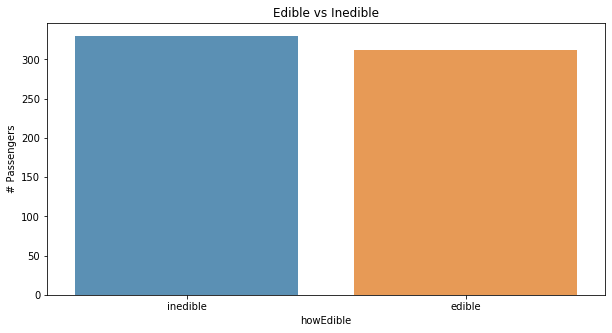

In [23]:
# Survival Count
print('Target Variable')
print(df.groupby(['howEdible']).howEdible.count())

# Target Variable Countplot
# sns.set_style('darkgrid')
plt.figure(figsize = (10,5))
sns.countplot(df['howEdible'], alpha =.80)
plt.title('Edible vs Inedible')
plt.ylabel('# Passengers')
plt.show()

Now lets get a general feel for all of the variable counts

Text(0.5, 1.0, 'hymeniumType')

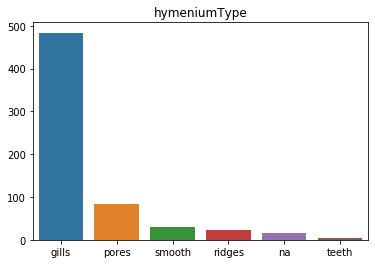

In [24]:
hc= dfx.hymeniumType.value_counts()
sns.barplot(hc.index, hc.values)
plt.title('hymeniumType')

Text(0.5, 1.0, 'capShape')

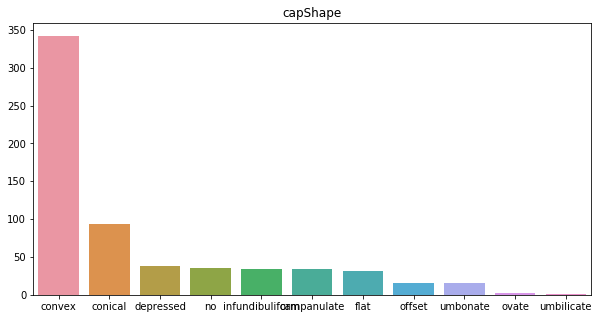

In [26]:
hc= dfx.capShape.value_counts()
plt.figure(figsize=(10,5))
sns.barplot(hc.index, hc.values)
plt.title('capShape')

Text(0.5, 1.0, 'whichGills')

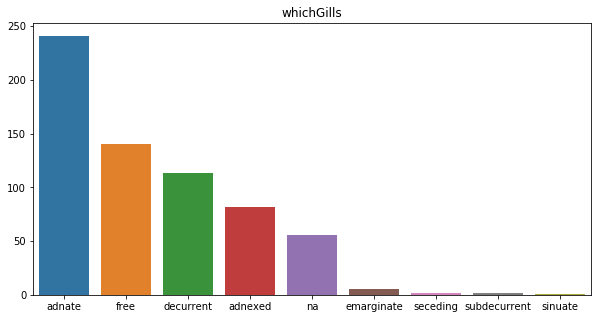

In [27]:
hc= dfx.whichGills.value_counts()
plt.figure(figsize=(10,5))
sns.barplot(hc.index, hc.values)
plt.title('whichGills')

Text(0.5, 1.0, 'stipeCharacter')

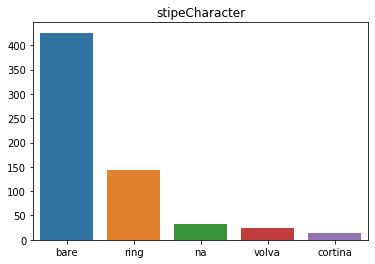

In [28]:
hc= dfx.stipeCharacter.value_counts()
sns.barplot(hc.index, hc.values)
plt.title('stipeCharacter')

Text(0.5, 1.0, 'sporePrintColor')

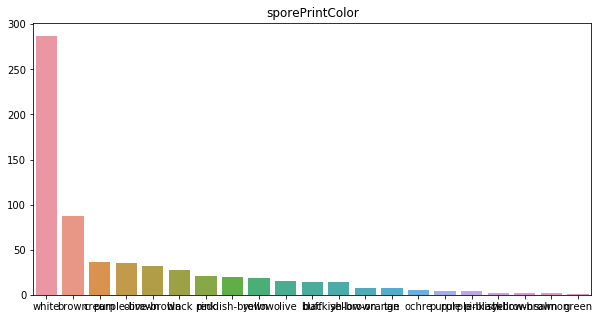

In [29]:
hc= dfx.sporePrintColor.value_counts()
plt.figure(figsize=(10,5))
sns.barplot(hc.index, hc.values)
plt.title('sporePrintColor')

Text(0.5, 1.0, 'ecologicalType')

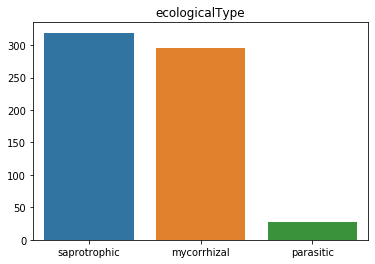

In [30]:
hc= dfx.ecologicalType.value_counts()
sns.barplot(hc.index, hc.values)
plt.title('ecologicalType')

Text(0.5, 1.0, 'genus')

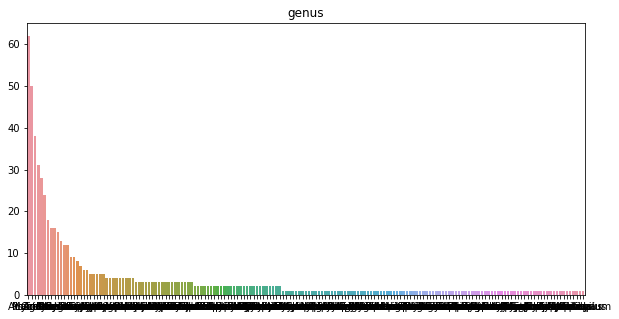

In [31]:
hc= dfx.genus.value_counts()
plt.figure(figsize=(10,5))
sns.barplot(hc.index, hc.values)
plt.title('genus')

In [32]:
df.groupby(['hymeniumType','howEdible']).hymeniumType.count().unstack()

howEdible,edible,inedible
hymeniumType,,
gills,217,267
na,8,9
pores,49,35
ridges,21,1
smooth,14,16
teeth,3,2


whichGills vs edibility


howEdible     edible  inedible
whichGills                    
adnate         116.0     125.0
adnexed         36.0      46.0
decurrent       62.0      51.0
emarginate       4.0       1.0
free            63.0      77.0
na              30.0      26.0
seceding         NaN       2.0
sinuate          1.0       NaN
subdecurrent     NaN       2.0


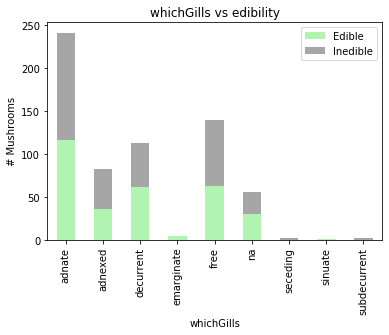

In [34]:

# Passenger class summary
print('whichGills vs edibility')

print('\n')
print(df.groupby(['whichGills','howEdible']).hymeniumType.count().unstack())

# Passenger class visualization
hymeniumType = df.groupby(['whichGills','howEdible']).hymeniumType.count().unstack()
p1 = hymeniumType.plot(kind = 'bar', stacked = True, 
                   title = 'whichGills vs edibility', 
                   color = ['lightgreen','gray'], alpha = .70)
p1.set_xlabel('whichGills')
p1.set_ylabel('# Mushrooms')
p1.legend(['Edible','Inedible'])
plt.show()

hymeniumType vs edibility


howEdible     edible  inedible
hymeniumType                  
gills            217       267
na                 8         9
pores             49        35
ridges            21         1
smooth            14        16
teeth              3         2


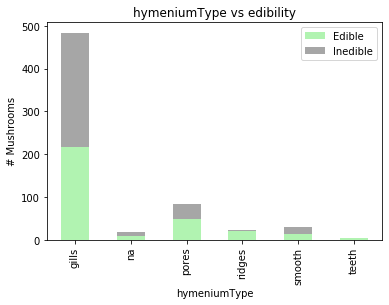

In [35]:

# Passenger class summary
print('hymeniumType vs edibility')

print('\n')
print(df.groupby(['hymeniumType','howEdible']).hymeniumType.count().unstack())

# Passenger class visualization
hymeniumType = df.groupby(['hymeniumType','howEdible']).hymeniumType.count().unstack()
p1 = hymeniumType.plot(kind = 'bar', stacked = True, 
                   title = 'hymeniumType vs edibility', 
                   color = ['lightgreen','gray'], alpha = .70)
p1.set_xlabel('hymeniumType')
p1.set_ylabel('# Mushrooms')
p1.legend(['Edible','Inedible'])
plt.show()

capShape vs edibility


howEdible        edible  inedible
capShape                         
campanulate        13.0      21.0
conical            33.0      60.0
convex            183.0     159.0
depressed          15.0      23.0
flat               17.0      14.0
infundibuliform    23.0      11.0
no                 14.0      22.0
offset              7.0       9.0
ovate               1.0       1.0
umbilicate          NaN       1.0
umbonate            6.0       9.0


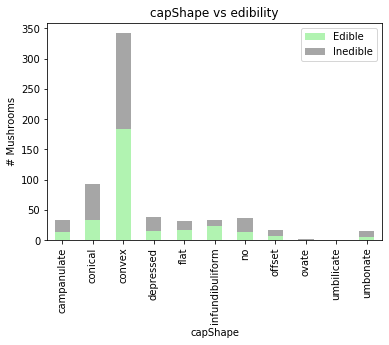

In [38]:

# Passenger class summary
print('capShape vs edibility')

print('\n')
print(df.groupby(['capShape','howEdible']).hymeniumType.count().unstack())

# Passenger class visualization
hymeniumType = df.groupby(['capShape','howEdible']).hymeniumType.count().unstack()
p1 = hymeniumType.plot(kind = 'bar', stacked = True, 
                   title = 'capShape vs edibility', 
                   color = ['lightgreen','gray'], alpha = .70)
p1.set_xlabel('capShape')
p1.set_ylabel('# Mushrooms')
p1.legend(['Edible','Inedible'])
plt.show()

Looks like ridges is only hymeniumType predictor that gives strong indication

## For now we will move to analysis

In [76]:
import itertools
from sklearn.metrics import confusion_matrix
#confusion matrix to be used later
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

divide data into x and y and training set and get dummies

In [133]:
data = pd.get_dummies(df.drop(columns=['name', 'howEdible']))
y = df['howEdible']
data.head()

,hymeniumType_gills,hymeniumType_na,hymeniumType_pores,hymeniumType_ridges,hymeniumType_smooth,hymeniumType_teeth,capShape_campanulate,capShape_conical,capShape_convex,capShape_depressed,...,genus_Tremella,genus_Tricholoma,genus_Tricholomopsis,genus_Turbinellus,genus_Tylopilus,genus_Verpa,genus_Volvariella,genus_Volvopluteus,genus_Xerocomellus,genus_Xerula
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [134]:
y.head()

0    inedible
1      edible
2      edible
3      edible
4      edible
Name: howEdible, dtype: object

In [135]:
#break up data for testing and training
data_train, data_test, y_train, y_test = train_test_split(data, y,test_size=.2)
print(len(data_train), len(data_test))

513 129


In [136]:
pd.DataFrame(y_test).howEdible.value_counts()

edible      69
inedible    60
Name: howEdible, dtype: int64

## Regular Tree

In [142]:
#function used to plot feature importance
def plot_feature_importances(model):
    n_features = data_train.shape[1]
    plt.figure(figsize=(40,40))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), data_train.columns.values) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')

In [137]:
# Instantiate and fit a DecisionTreeClassifier
tree_clf = DecisionTreeClassifier(criterion='gini', max_depth=30) 
tree_clf.fit(data_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=30,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

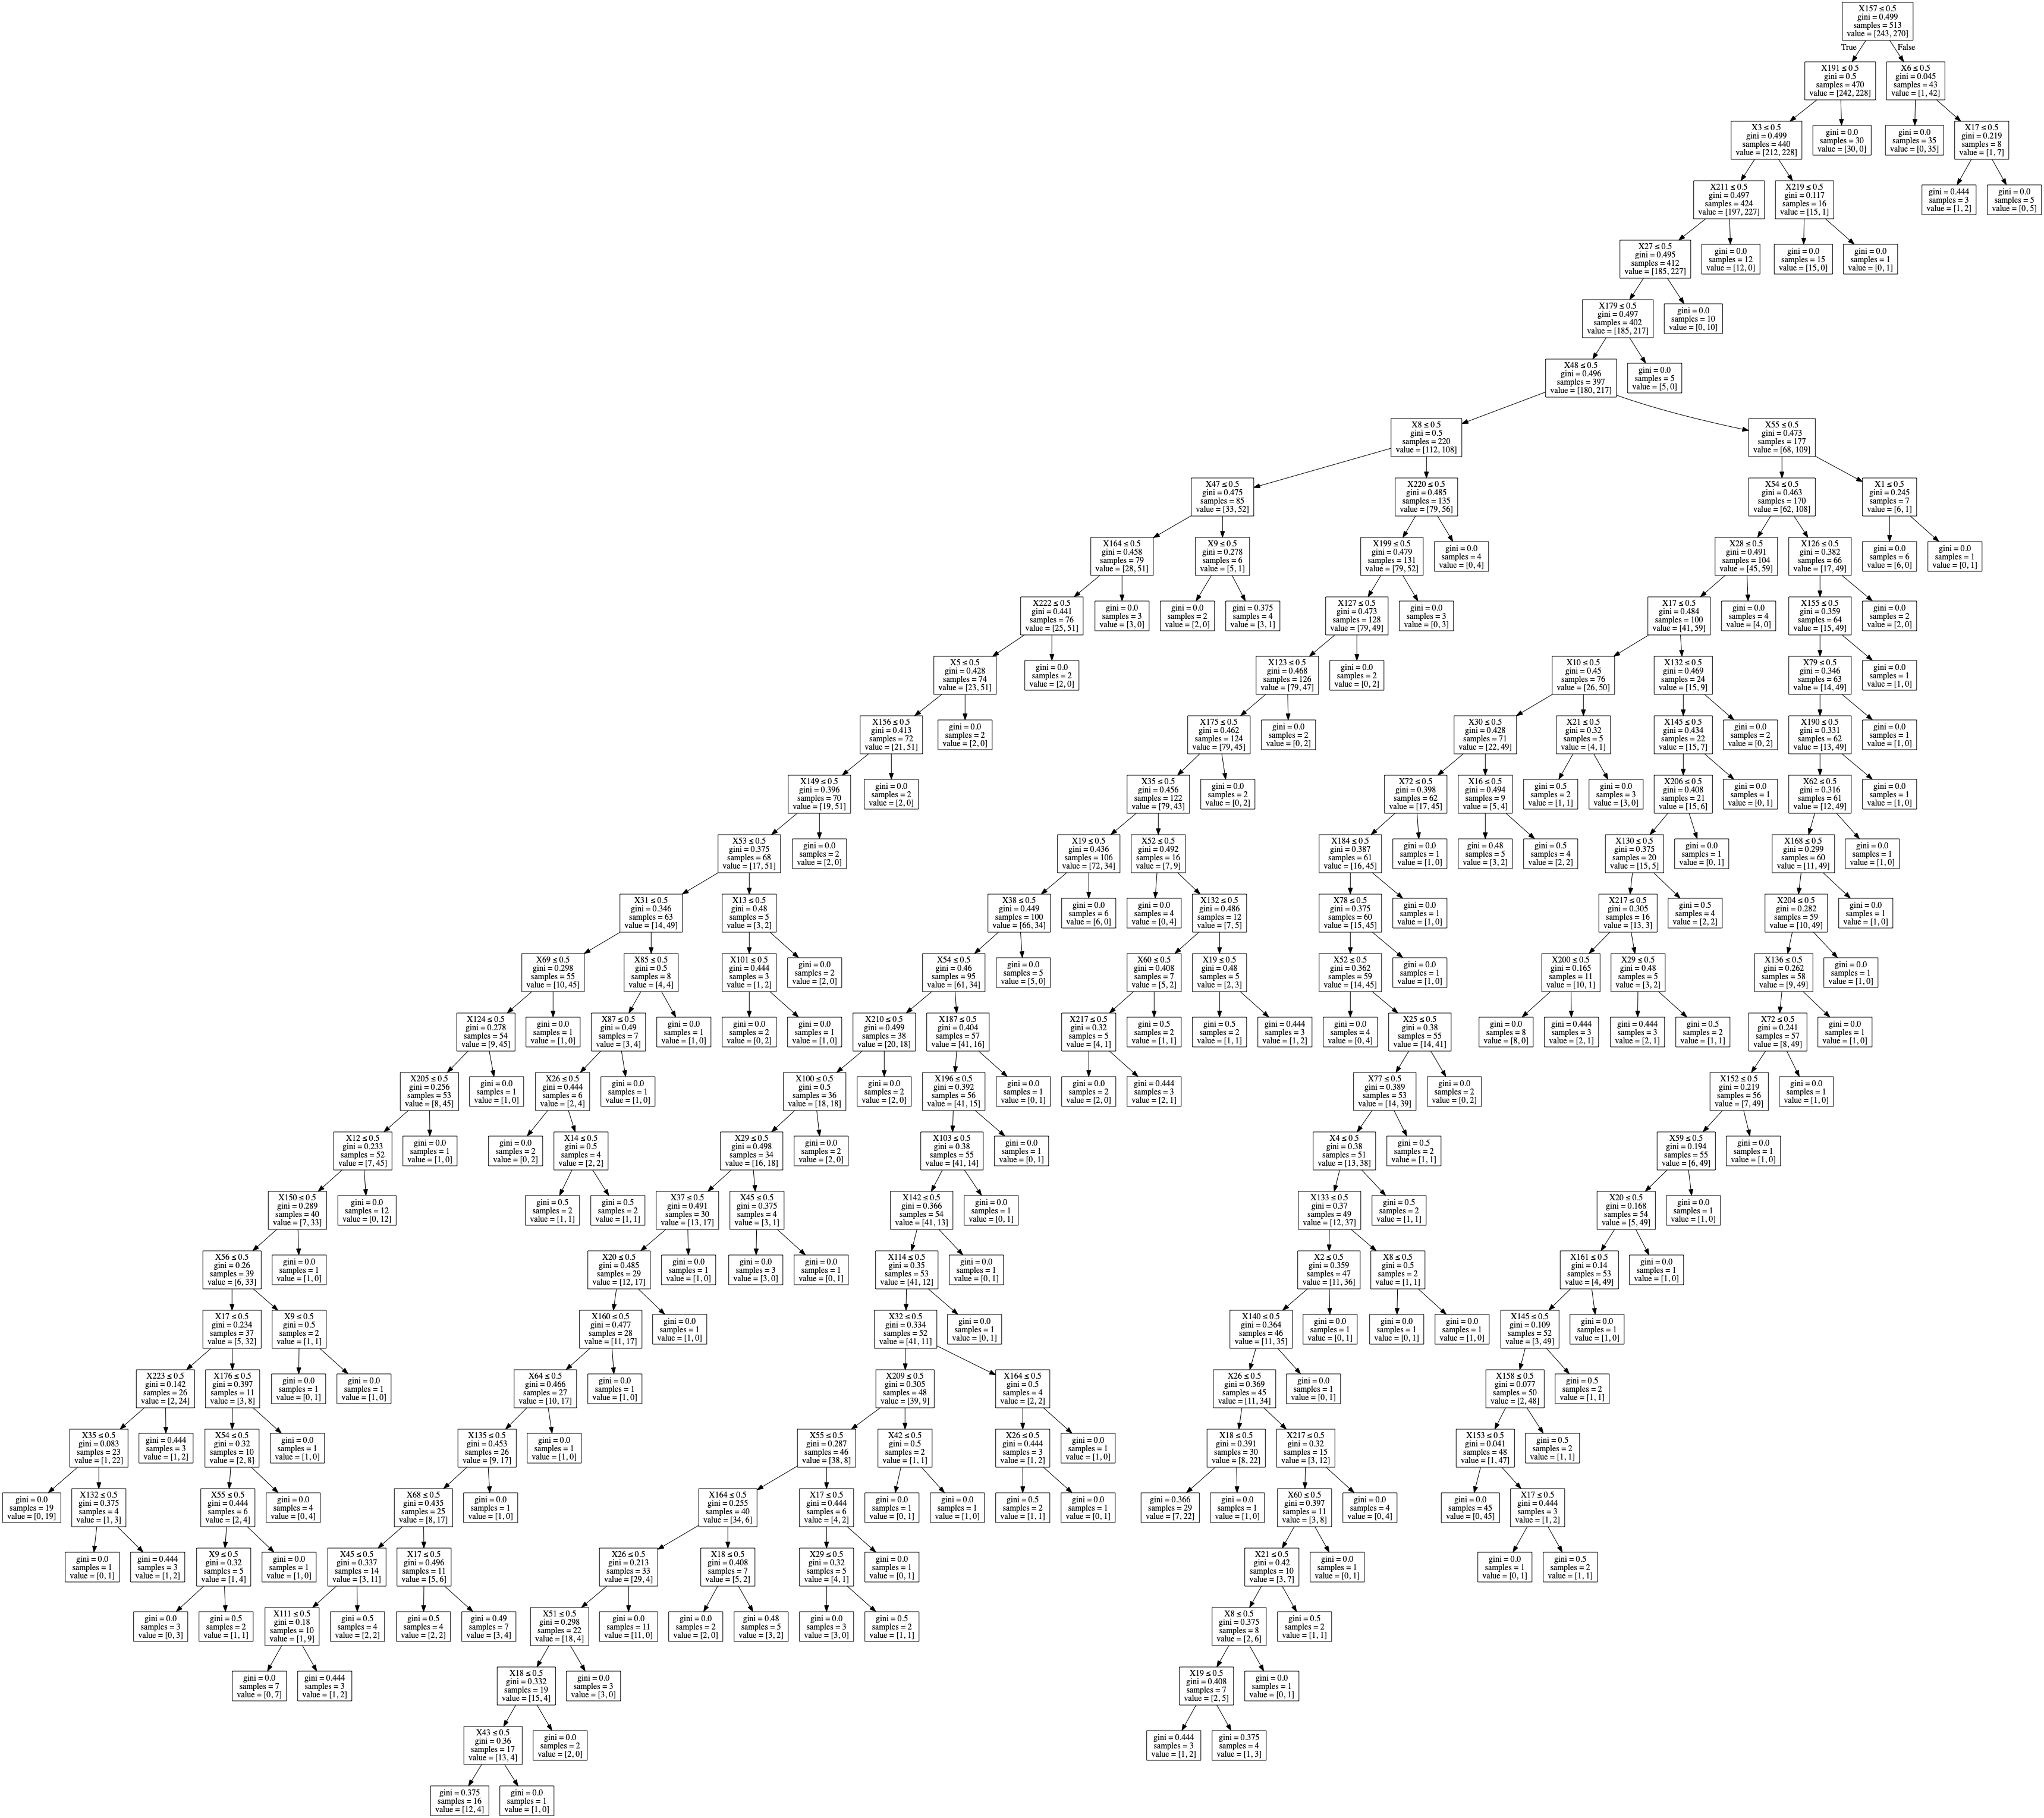

In [138]:
# visualizing the regression tree
dot_data = StringIO()
export_graphviz(tree_clf, out_file=dot_data,  
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

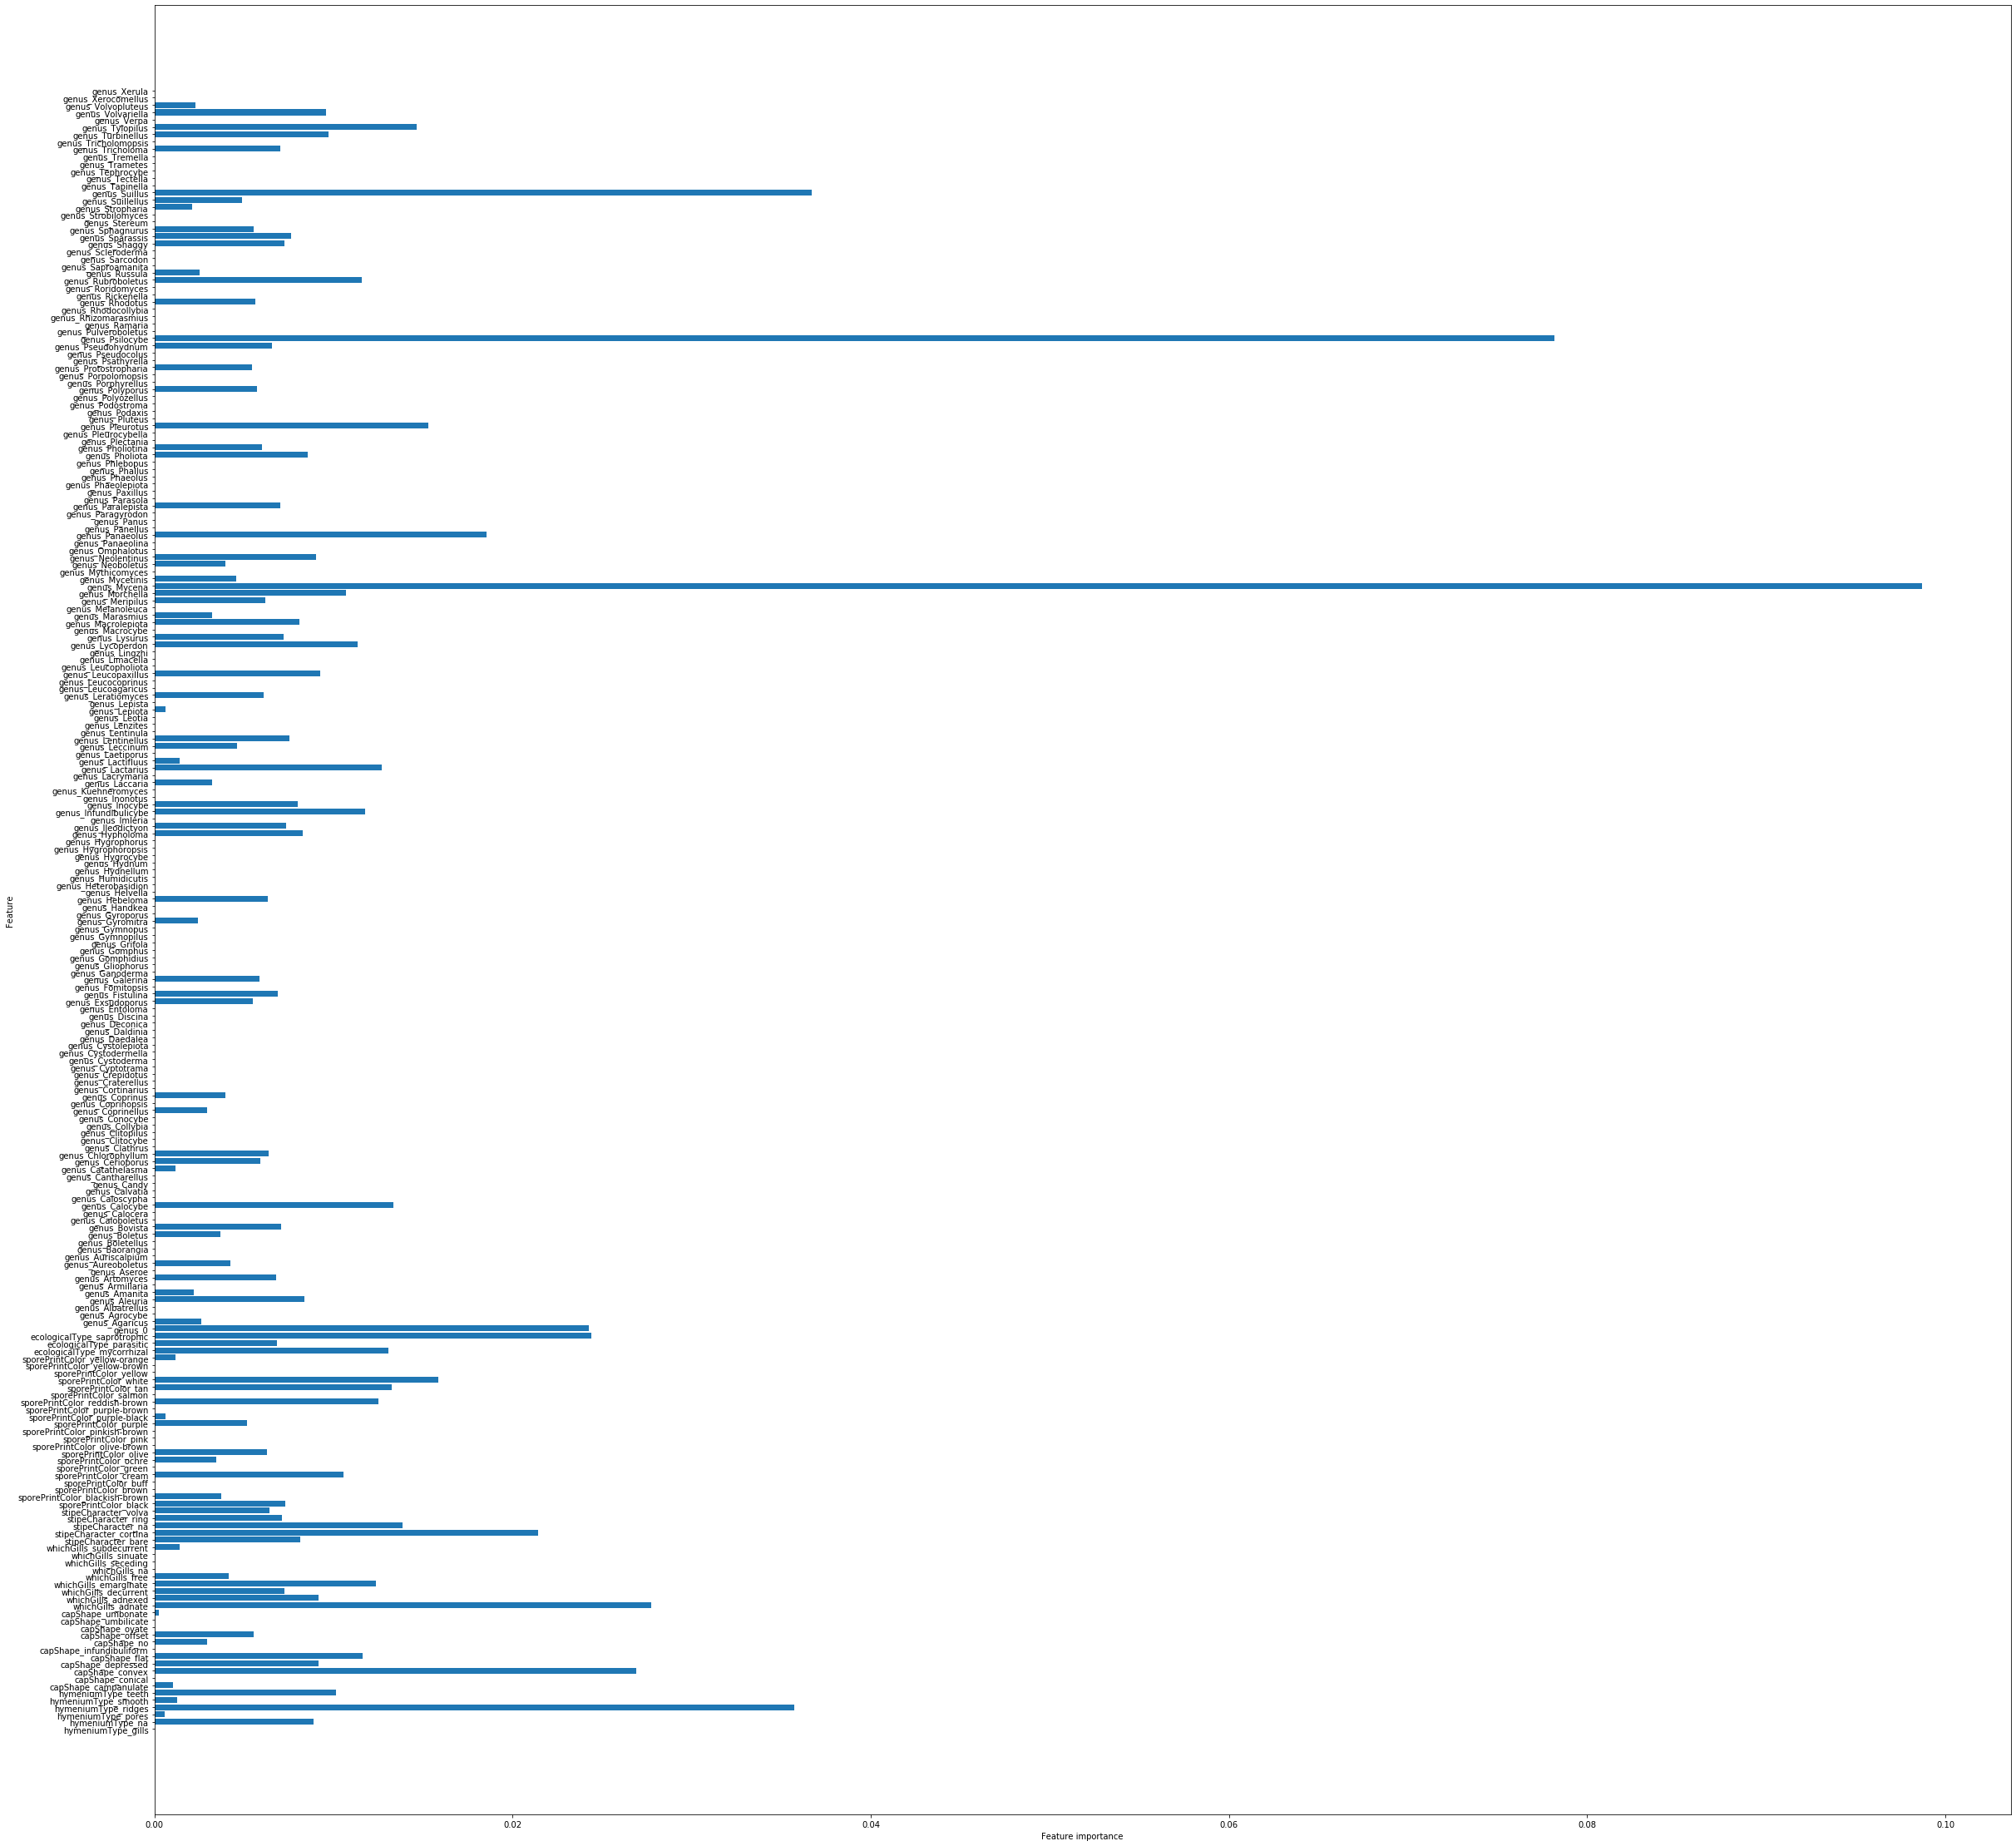

In [143]:
plot_feature_importances(tree_clf)

In [85]:
# Test set predictions
pred = tree_clf.predict(data_test)

# Confusion matrix and classification report
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

[[42 18]
 [25 44]]
              precision    recall  f1-score   support

      edible       0.63      0.70      0.66        60
    inedible       0.71      0.64      0.67        69

    accuracy                           0.67       129
   macro avg       0.67      0.67      0.67       129
weighted avg       0.67      0.67      0.67       129



In [86]:
cm = confusion_matrix(y_test, pred)
classes = ['Edible', 'Inedible']

# cm = confusion_matrix(y_test,y_pred_class)
# classes = ['Perished', 'Survived']

Confusion Matrix, without normalization
[[42 18]
 [25 44]]


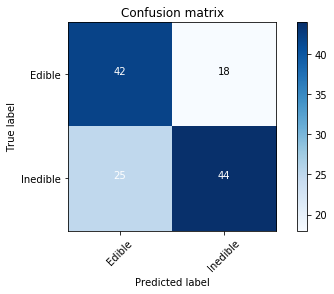

In [87]:
import itertools
plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)

In [88]:
# Training accuracy score
tree_clf.score(data_train, y_train)

0.9259259259259259

In [89]:
# Test accuracy score
tree_clf.score(data_test, y_test)

0.6666666666666666

## Random Forest

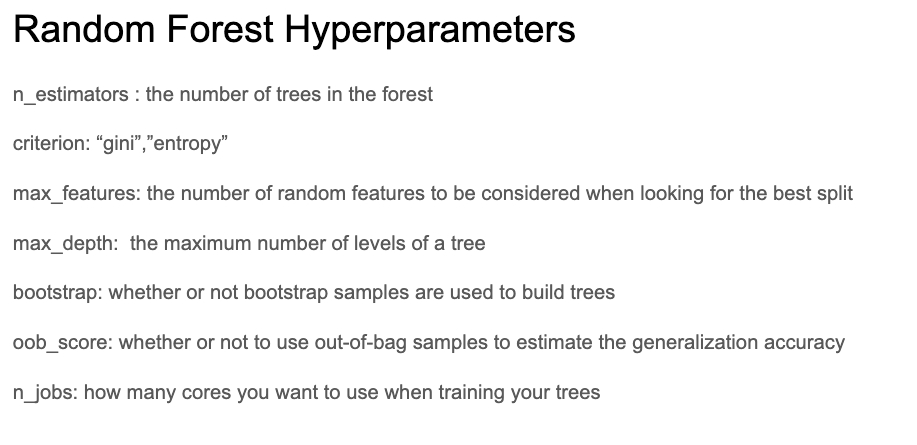

In [90]:
# Instantiate and fit a RandomForestClassifier
forest = RandomForestClassifier(n_estimators=10000)
forest.fit(data_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [91]:
# Forest with genus
predrf = forest.predict(data_test)

# Confusion matrix and classification report
print(confusion_matrix(y_test, predrf))
print(classification_report(y_test, predrf))

[[44 16]
 [22 47]]
              precision    recall  f1-score   support

      edible       0.67      0.73      0.70        60
    inedible       0.75      0.68      0.71        69

    accuracy                           0.71       129
   macro avg       0.71      0.71      0.71       129
weighted avg       0.71      0.71      0.71       129



Confusion Matrix, without normalization
[[44 16]
 [22 47]]


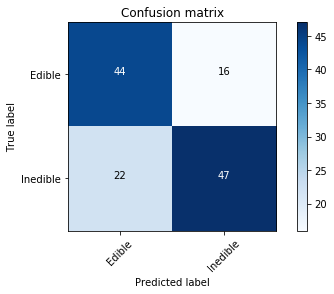

In [92]:
cm = confusion_matrix(y_test, predrf)
classes = ['Edible', 'Inedible']
plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)

In [93]:
# Training accuracy score
forest.score(data_train, y_train)

0.9259259259259259

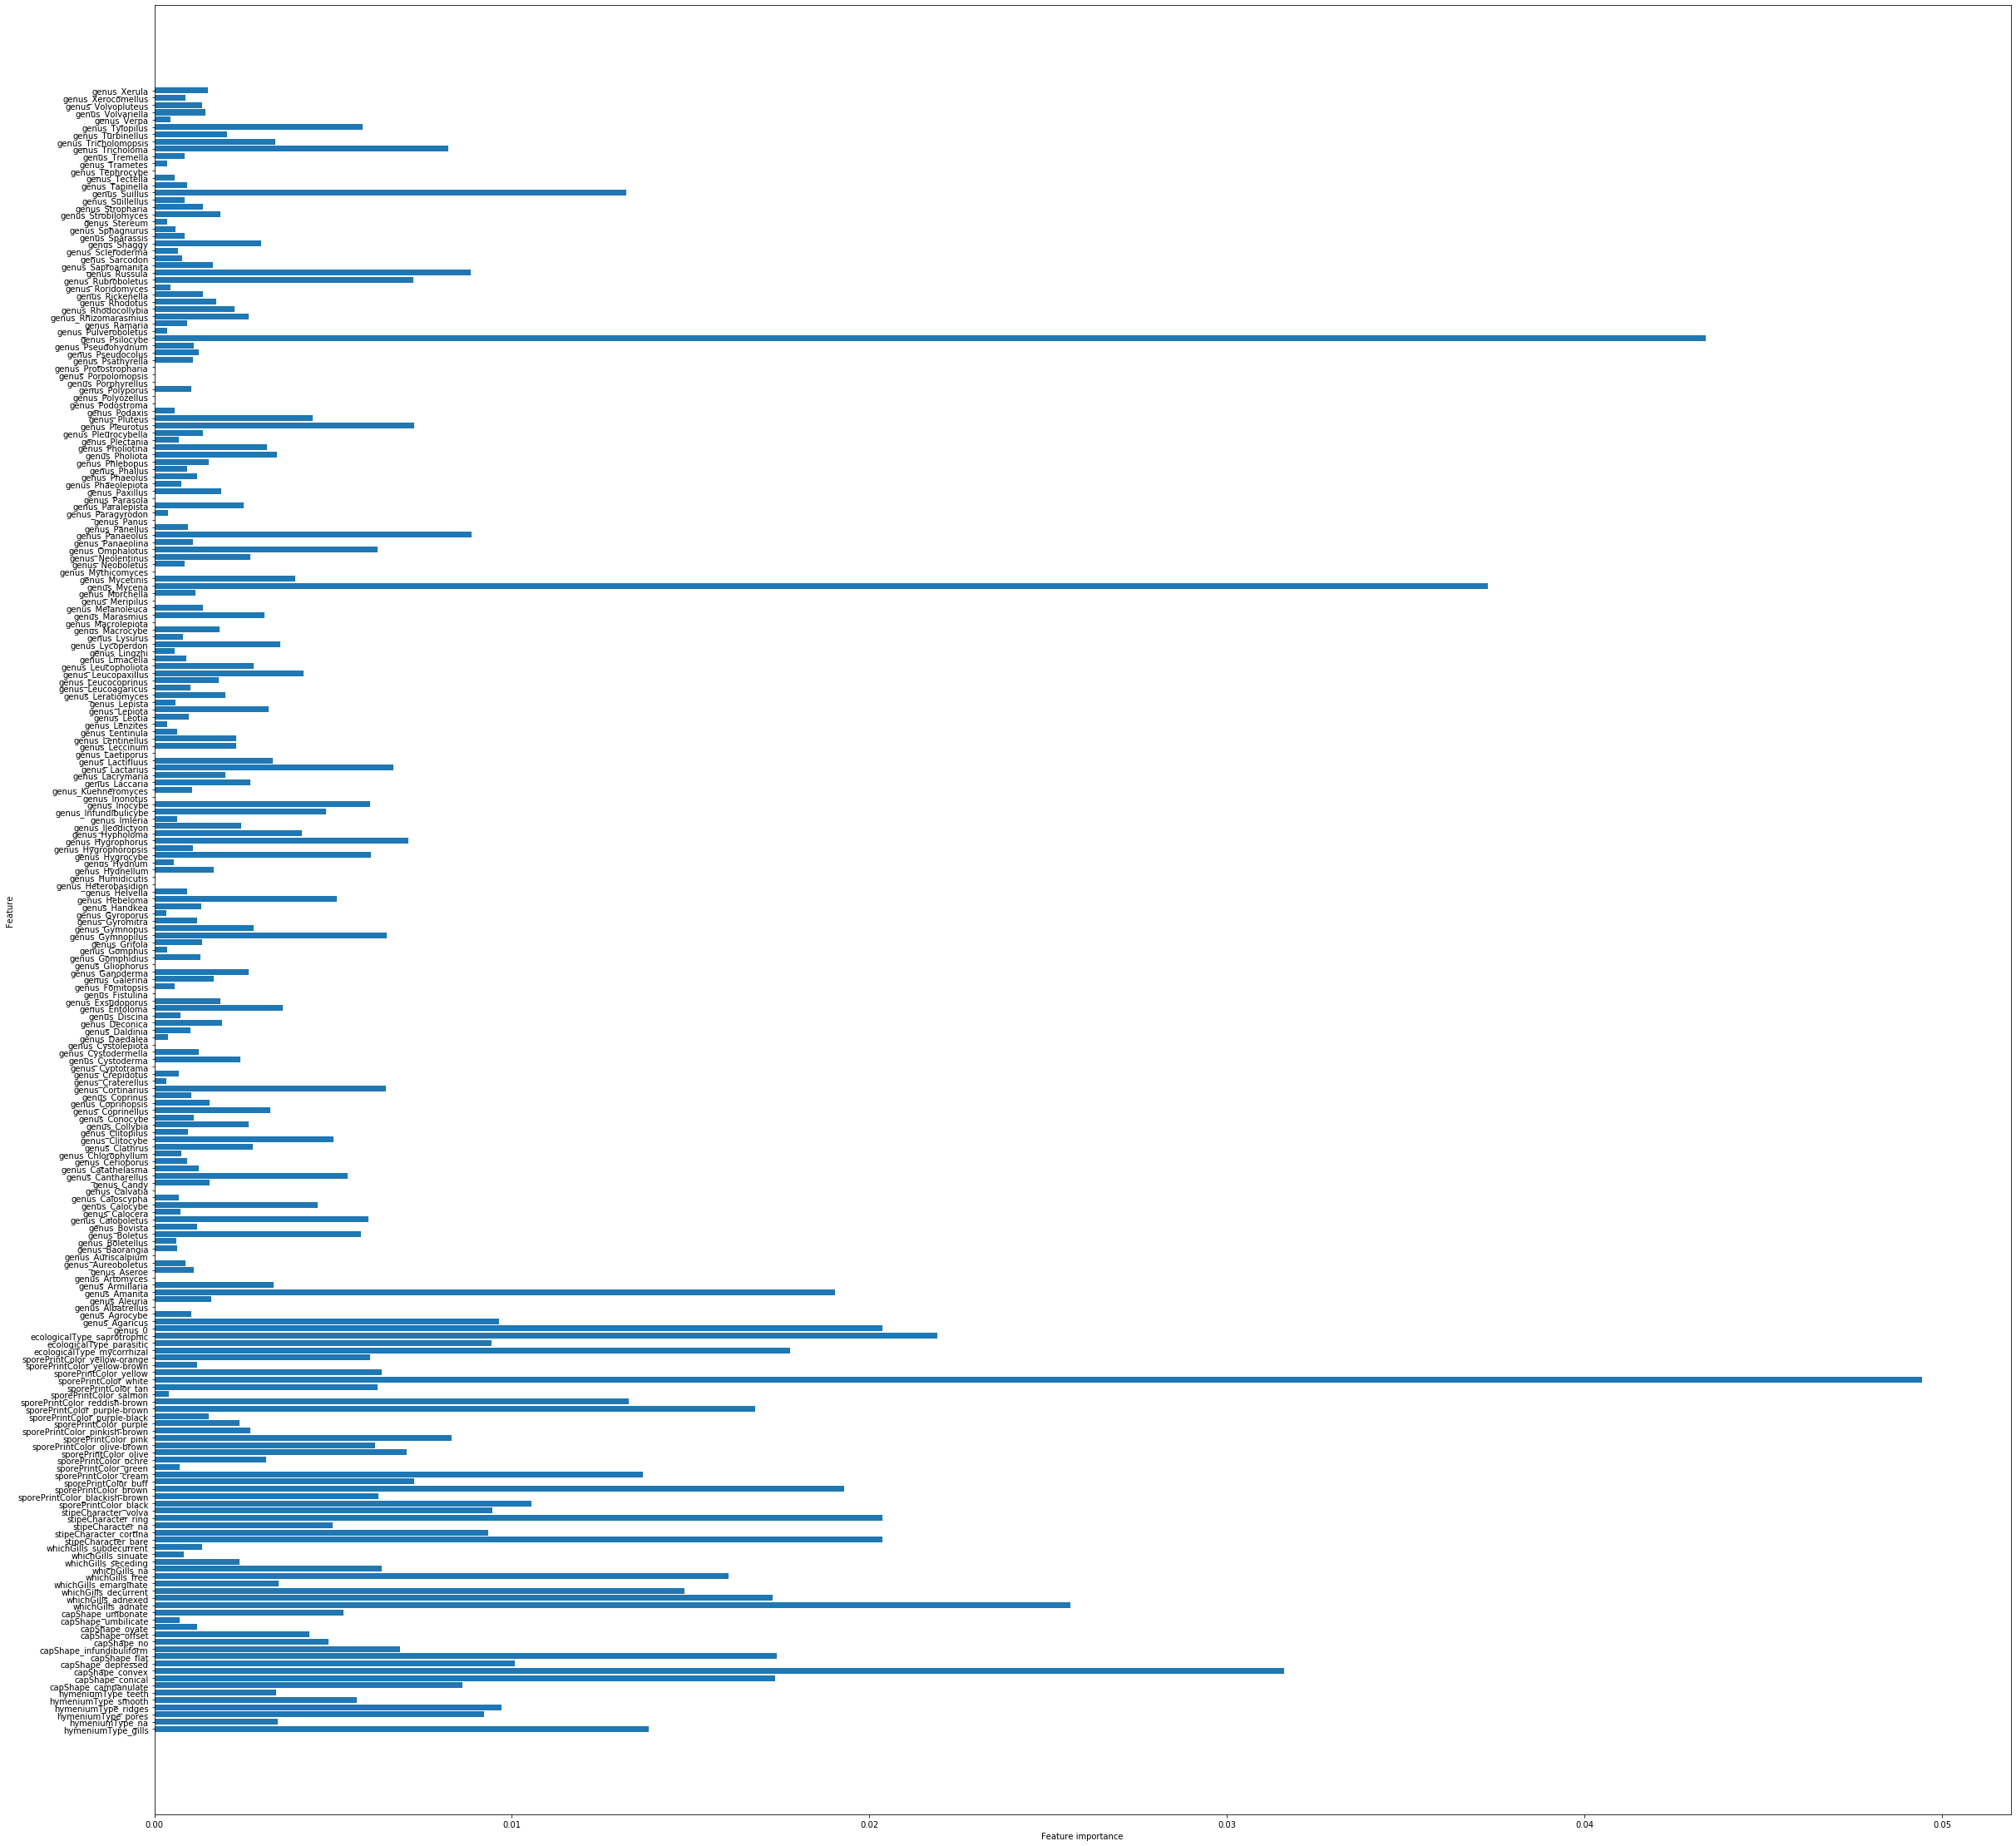

In [94]:
plot_feature_importances(forest)

In [95]:
# Test accuracy score
forest.score(data_test, y_test)

0.7054263565891473

# Omitting Genus

In [144]:
data = pd.get_dummies(df.drop(columns=['name', 'howEdible', 'genus']))
y = df['howEdible']
#break up data for testing and training
data_train, data_test, y_train, y_test = train_test_split(data, y,test_size=.2)
data.head()

,hymeniumType_gills,hymeniumType_na,hymeniumType_pores,hymeniumType_ridges,hymeniumType_smooth,hymeniumType_teeth,capShape_campanulate,capShape_conical,capShape_convex,capShape_depressed,...,sporePrintColor_reddish-brown,sporePrintColor_salmon,sporePrintColor_tan,sporePrintColor_white,sporePrintColor_yellow,sporePrintColor_yellow-brown,sporePrintColor_yellow-orange,ecologicalType_mycorrhizal,ecologicalType_parasitic,ecologicalType_saprotrophic
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
2,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
3,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
4,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1


In [145]:
# Instantiate and fit a RandomForestClassifier
forest = RandomForestClassifier(n_estimators=2000)
forest.fit(data_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=2000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [146]:
# Test set predictions
pred_rf = forest.predict(data_test)

# Confusion matrix and classification report
print(confusion_matrix(y_test, pred_rf))
print(classification_report(y_test, pred_rf))

[[54 19]
 [16 40]]
              precision    recall  f1-score   support

      edible       0.77      0.74      0.76        73
    inedible       0.68      0.71      0.70        56

    accuracy                           0.73       129
   macro avg       0.72      0.73      0.73       129
weighted avg       0.73      0.73      0.73       129



Confusion Matrix, without normalization
[[54 19]
 [16 40]]


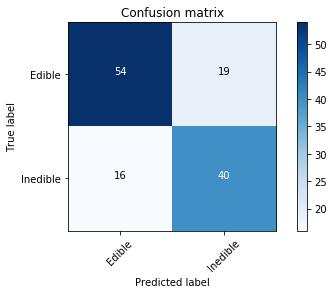

In [147]:
cm = confusion_matrix(y_test, pred_rf)
classes = ['Edible', 'Inedible']
plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)

In [148]:
# Training accuracy score
forest.score(data_train, y_train)

0.8557504873294347

In [149]:
# Test accuracy score
forest.score(data_test, y_test)

0.7286821705426356

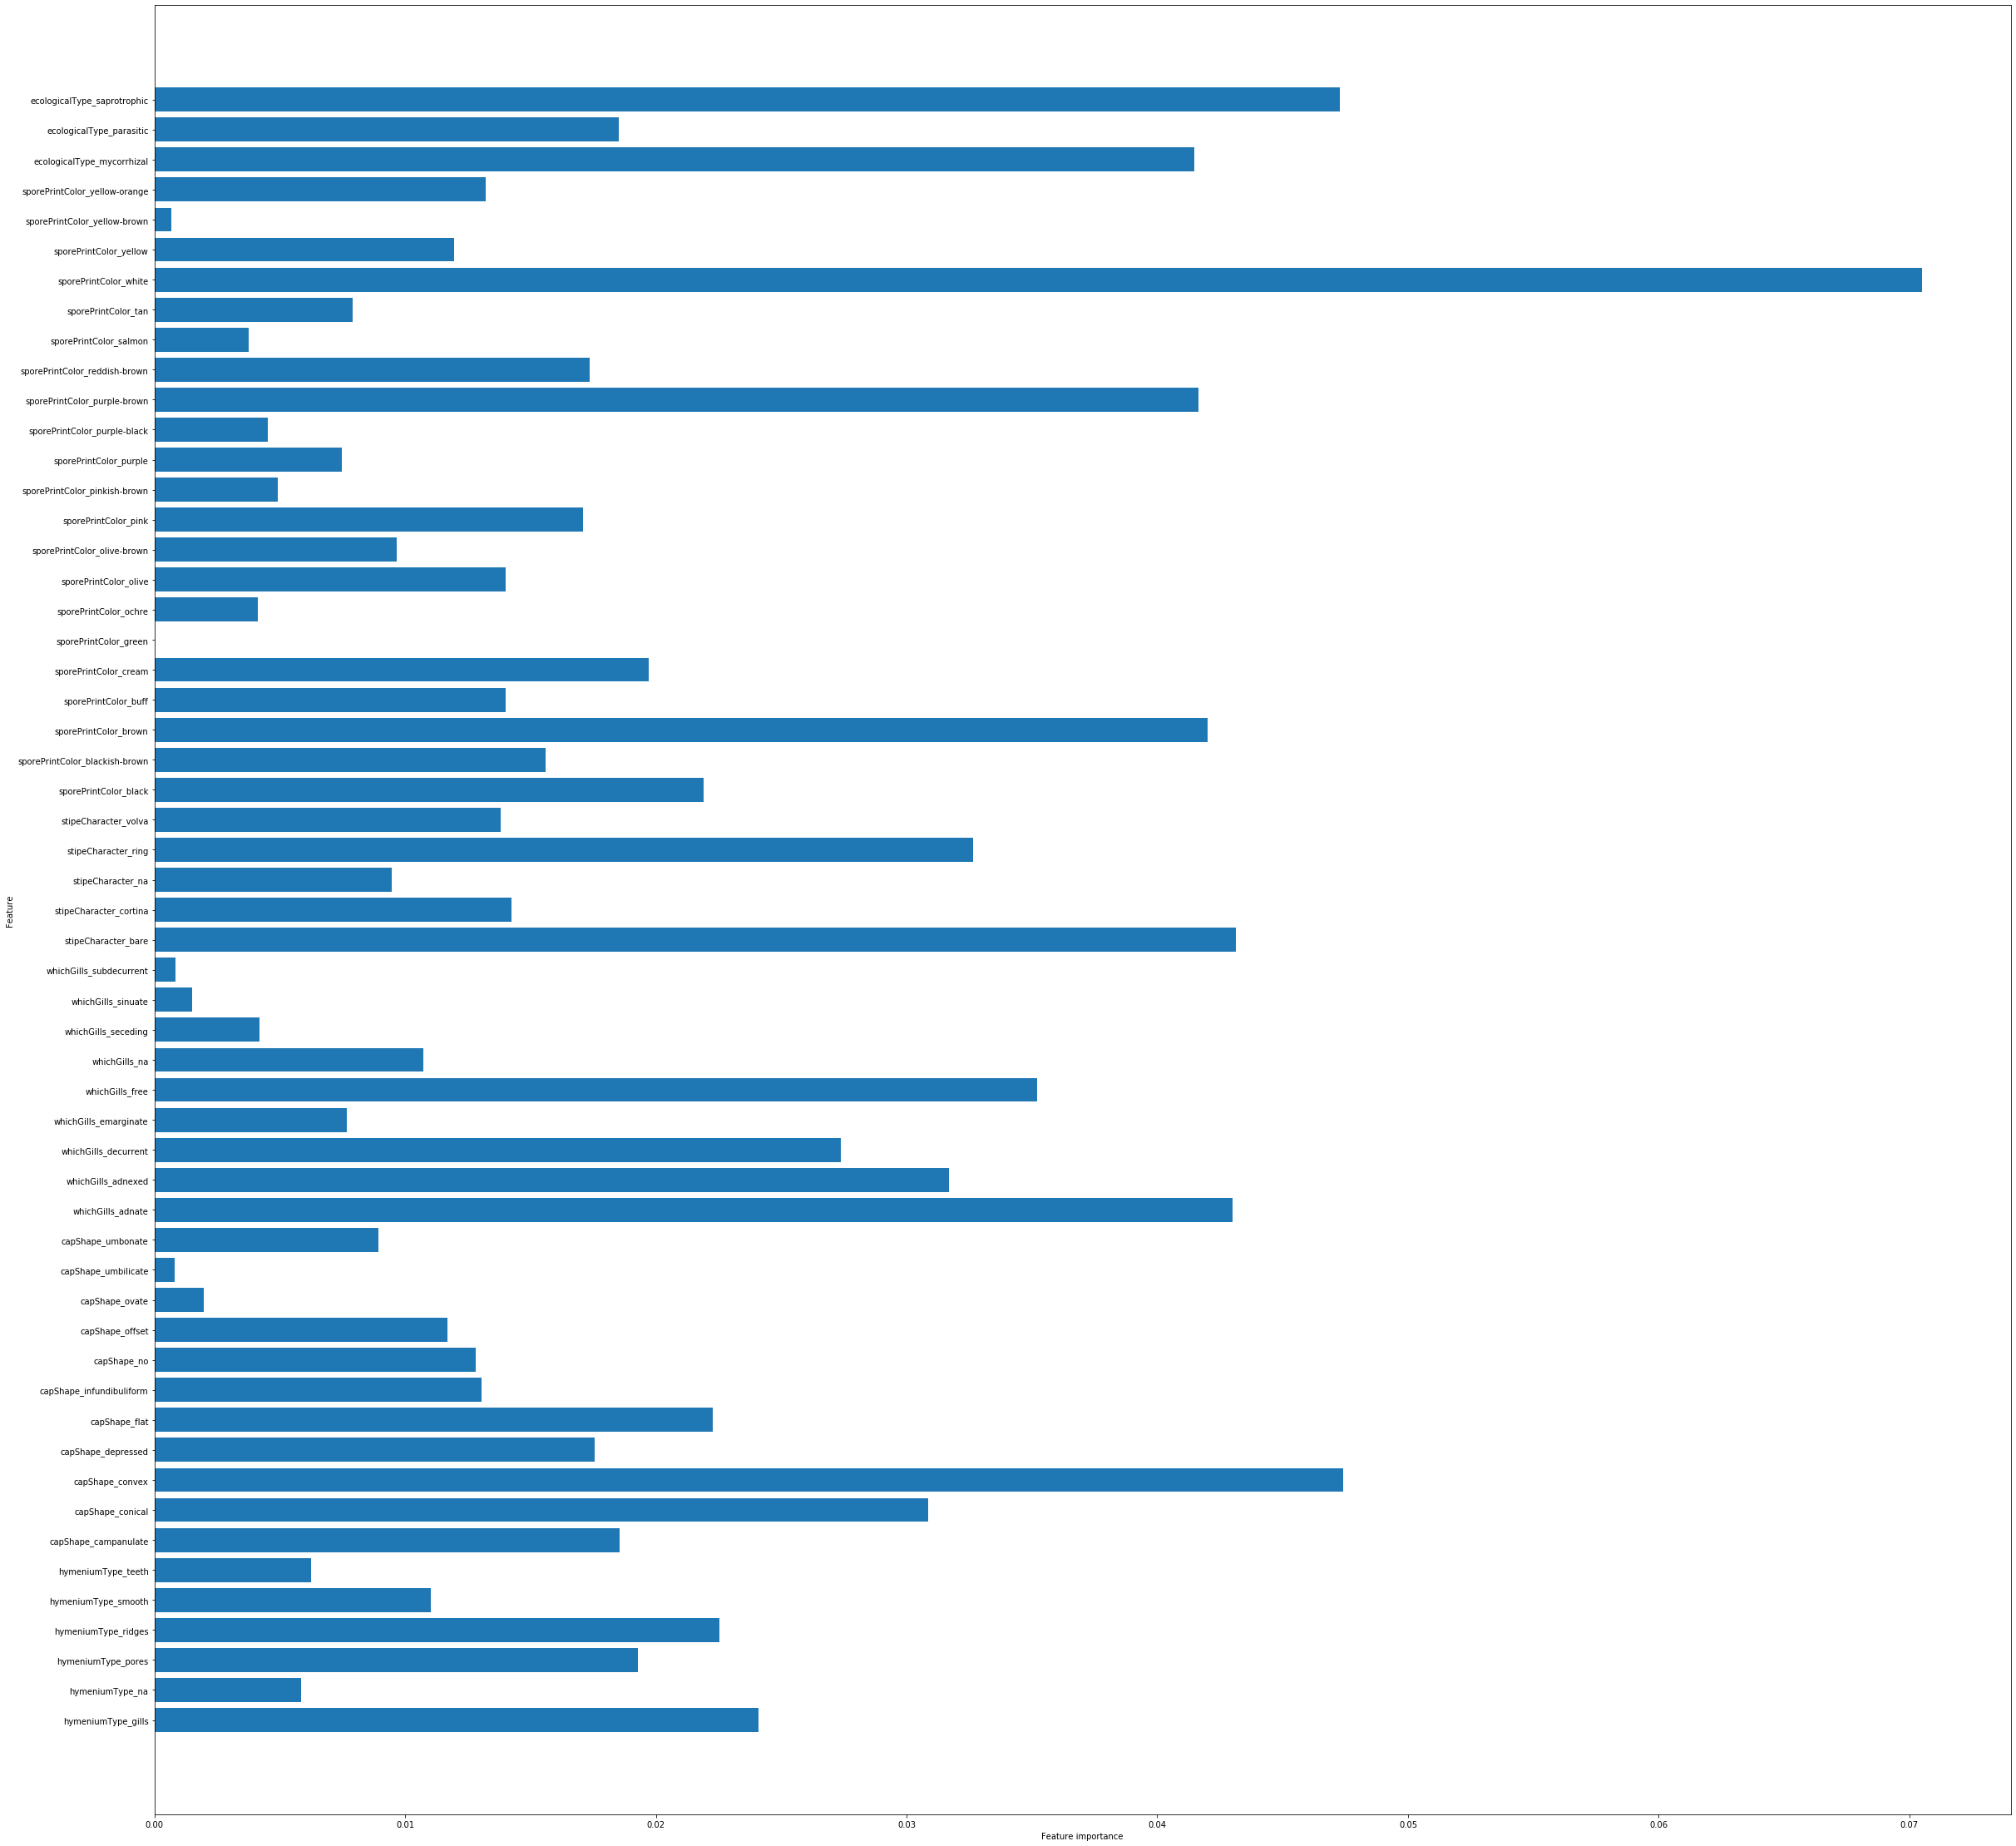

In [150]:
plot_feature_importances(forest)

### Now get ROC for Random Forest (currently under repair)

In [151]:
# fpr, tpr, thresholds = metrics.roc_curve(y_test, pred_rf)
# plt.plot(fpr, tpr)
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.0])
# plt.title('ROC curve for diabetes classifier')
# plt.xlabel('False Positive Rate (1 - Specificity)')
# plt.ylabel('True Positive Rate (Sensitivity)')
# plt.grid(True)

## Use XGBoost on df without genus

In [105]:
from xgboost import XGBClassifier

In [106]:
# Instantiate XGBClassifier
clf = XGBClassifier(n_estimators=10000)

In [107]:
# Fit XGBClassifier
clf.fit(data_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=10000, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [108]:
# Predict on training and test sets
training_preds_XG = clf.predict(data_train)
test_preds_XG = clf.predict(data_test)

# Accuracy of training and test sets
training_accuracy = accuracy_score(y_train, training_preds_XG)
test_accuracy = accuracy_score(y_test, test_preds_XG)

In [109]:
print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
print('Validation accuracy: {:.4}%'.format(test_accuracy * 100))

Training Accuracy: 89.67%
Validation accuracy: 60.47%


In [110]:

# Confusion matrix and classification report
print(confusion_matrix(y_test, test_preds_XG))
print(classification_report(y_test, test_preds_XG))

[[38 22]
 [29 40]]
              precision    recall  f1-score   support

      edible       0.57      0.63      0.60        60
    inedible       0.65      0.58      0.61        69

    accuracy                           0.60       129
   macro avg       0.61      0.61      0.60       129
weighted avg       0.61      0.60      0.60       129



Confusion Matrix, without normalization
[[38 22]
 [29 40]]


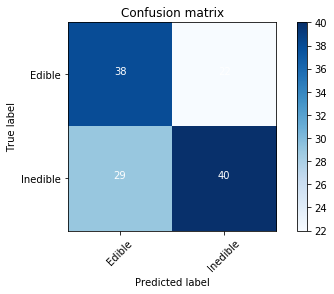

In [111]:
cm = confusion_matrix(y_test, test_preds_XG)
classes = ['Edible', 'Inedible']
plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)

In [112]:
clf.score(data_train, y_train)

0.8966861598440545

In [113]:
# Test accuracy score
clf.score(data_test, y_test)

0.6046511627906976

### Automate tuining Process

In [156]:
from sklearn.model_selection import GridSearchCV
#tuning process
param_grid = {
    'learning_rate': [0.1, ],
    'max_depth': [8,10,12],
    'min_child_weight': [1],
    'subsample': [0.5,.7],
    'n_estimators': [500,2000],
}

grid_clf = GridSearchCV(clf, param_grid, scoring='accuracy', cv=3, n_jobs=1)
grid_clf.fit(data_train, y_train)

best_parameters = grid_clf.best_params_

print('Grid Search found the following optimal parameters: ')
for param_name in sorted(best_parameters.keys()):
    print('%s: %r' % (param_name, best_parameters[param_name]))

training_preds = grid_clf.predict(data_train)
test_preds = grid_clf.predict(data_test)
training_accuracy = accuracy_score(y_train, training_preds)
test_accuracy = accuracy_score(y_test, test_preds)

Grid Search found the following optimal parameters: 
learning_rate: 0.1
max_depth: 12
min_child_weight: 1
n_estimators: 500
subsample: 0.7


In [157]:
print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
print('Validation accuracy: {:.4}%'.format(test_accuracy * 100))

Training Accuracy: 85.19%
Validation accuracy: 68.99%


Confusion Matrix, without normalization
[[51 22]
 [18 38]]


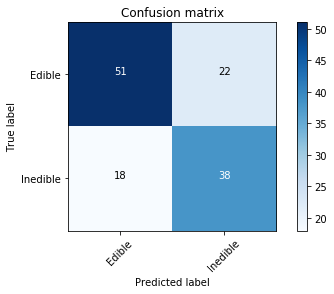

In [158]:
cm = confusion_matrix(y_test, test_preds)
classes = ['Edible', 'Inedible']
plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)

In [ ]:
data = pd.get_dummies(df.drop(columns=['name', 'howEdible', 'genus']))
y = df['howEdible']
#break up data for testing and training
X_train, X_test, y_train, y_test = train_test_split(data, y,test_size=.2)
data.head()

In [ ]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logreg.fit(X_train, y_train)

In [ ]:
#idk if this works for classification
dictionary = dict(zip(list(X_train.columns), list(logreg.coef_[0])))
dictionary

In [ ]:
# make class predictions for the testing set
y_pred_class = logreg.predict(X_test)

In [ ]:
# calculate accuracy
from sklearn import metrics
print(metrics.accuracy_score(y_test, y_pred_class))

In [ ]:
# Confusion matrix and classification report
print(confusion_matrix(y_test, y_pred_class))
print(classification_report(y_test, y_pred_class))

In [ ]:
cm = confusion_matrix(y_test, y_pred_class)
classes = ['Edible', 'Inedible']
plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)

In [ ]:
# examine the class distribution of the testing set (using a Pandas Series method)
y_test.value_counts()

### Look at AUC and ROC curves